# Training an encoder-decoder model

In [1]:
import numpy as np
import pylab as plt
from tqdm import tqdm
from astropy.stats import mad_std
from astroNN.apogee import allstar
from astroNN.shared import pylab_style
from astroNN.models import ApokascEncoderDecoder
from py.dataset_utils import APOKASC
from py.utils import powerspec_log_rebin_v2, numax_to_deltanu, gaussian_envelope_weights
from tensorflow import keras as tfk


pylab_style(paper=True)

apokasc_f = APOKASC()
freq_range = apokasc_f.get_powerspec_freqrange()
all_psd = apokasc_f.get_smoothed_flattened_powerspec()
freq_range, all_psd = powerspec_log_rebin_v2(freq_range, all_psd)

all_psd = np.log(all_psd)
contspec = apokasc_f.get_contspec()
contspec[contspec > 2.0] = 1.0

psd_training = np.array(all_psd)
spec_training = np.array(contspec)

all_sample_weight = np.stack(
    [gaussian_envelope_weights(x, freq_range) for x in apokasc_f.dataset["Numax"]]
)

# need to trim a few pixels because of deconvolution
nn_output_internal = psd_training.shape[1] // 4
psd_training = psd_training[:, : nn_output_internal * 4]
all_sample_weight = all_sample_weight[:, : nn_output_internal * 4]
freq_range = freq_range[: nn_output_internal * 4]

print("Number of APOGEE-Kepler pairs: ", len(psd_training))
print("Power Spectra pixel number: ", psd_training.shape[1])


Number of APOGEE-Kepler pairs:  9869
Power Spectra pixel number:  2092


[ 77.35554841 102.55448583  68.96252406  18.47980281   2.00476347]


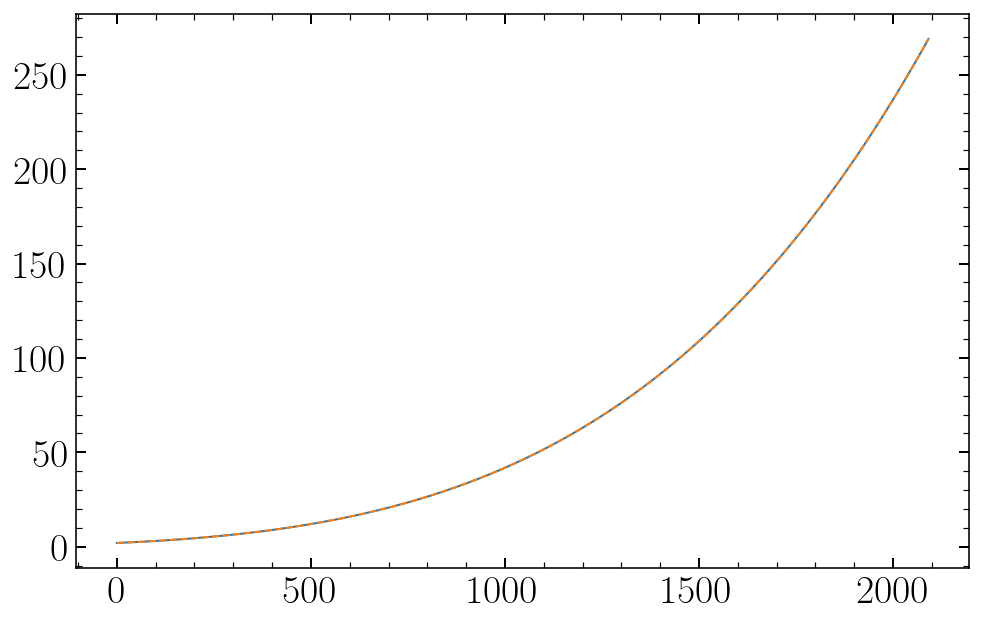

In [2]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(lambda x, a, b, c, d, e: a*x**4+b*x**3+c*x**2+d*x+e, np.arange(len(freq_range)) / 2092, freq_range)
x = np.arange(len(freq_range)) / 2092

plt.plot(x * 2092, freq_range)
plt.plot(x * 2092, popt[0]*x**4+popt[1]*x**3+popt[2]*x**2+popt[3]*x+popt[4], ls="--")
print(popt)

In [2]:
model = ApokascEncoderDecoder()
model.max_epochs = 150
model.val_size = 0.0
model.fit(
    spec_training[100:], psd_training[100:], sample_weight=all_sample_weight[100:]
)

Number of Training Data: 9769, Number of Validation Data: 0
====Message from Normalizer====
You selected mode: 2
Featurewise Center: {'input': True}
Datawise Center: {'input': False} 
Featurewise std Center: {'input': True}
Datawise std Center: {'input': False} 
====Message ends====
====Message from Normalizer====
You selected mode: 0
Featurewise Center: {'output': False}
Datawise Center: {'output': False} 
Featurewise std Center: {'output': False}
Datawise std Center: {'output': False} 
====Message ends====
Epoch 1/150
76/76 - 6s - loss: 290.6515 - reconstruction_loss: 289.7136 - kl_loss: 0.9378 - lr: 5.0000e-04 - 6s/epoch - 80ms/step
Epoch 2/150
76/76 - 2s - loss: 286.2291 - reconstruction_loss: 286.2134 - kl_loss: 0.0157 - lr: 5.0000e-04 - 2s/epoch - 27ms/step
Epoch 3/150
76/76 - 2s - loss: 286.1893 - reconstruction_loss: 286.1727 - kl_loss: 0.0166 - lr: 5.0000e-04 - 2s/epoch - 26ms/step
Epoch 4/150
76/76 - 2s - loss: 286.1331 - reconstruction_loss: 286.1065 - kl_loss: 0.0266 - lr: 

In [6]:
model.save("./models/astroNN_VEncoderDecoder/")

model_weights.h5 saved to c:\Users\Henry\Documents\Notebooks\astroNN_ages\models\astroNN_VEncoderDecoder\model_weights.h5


## Quick check the trained model

In [1]:
import numpy as np
import pylab as plt
from tqdm import tqdm
from astropy.stats import mad_std
from astroNN.apogee import allstar
from astroNN.shared import pylab_style
from astroNN.models import ApokascEncoderDecoder
from py.dataset_utils import APOKASC
from py.utils import powerspec_log_rebin_v2, ES_num_to_word
from astroNN.models import load_folder
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

pylab_style(paper=True)

apokasc_f = APOKASC()
freq_range = apokasc_f.get_powerspec_freqrange()
all_psd = apokasc_f.get_smoothed_flattened_powerspec()
freq_range, all_psd = powerspec_log_rebin_v2(freq_range, all_psd)

all_psd = np.log(all_psd)
contspec = apokasc_f.get_contspec()
contspec[contspec > 2.0] = 1.0

psd_training = np.array(all_psd)
spec_training = np.array(contspec)

# need to trim a few pixels because of deconvolution
nn_output_internal = psd_training.shape[1] // 4
psd_training = psd_training[:, : nn_output_internal * 4]
freq_range = freq_range[: nn_output_internal * 4]

model = load_folder("./models/astroNN_VEncoderDecoder/")

recont = model.predict(spec_training)
z_mean, z_stdev, z = model.predict_encoder(spec_training)

Loaded astroNN model, model type: Convolutional Variational Autoencoder -> ApokascEncoderDecoder


Prediction progress: 100%|██████████| 9869/9869 [00:00<00:00, 19542.92sample/s]


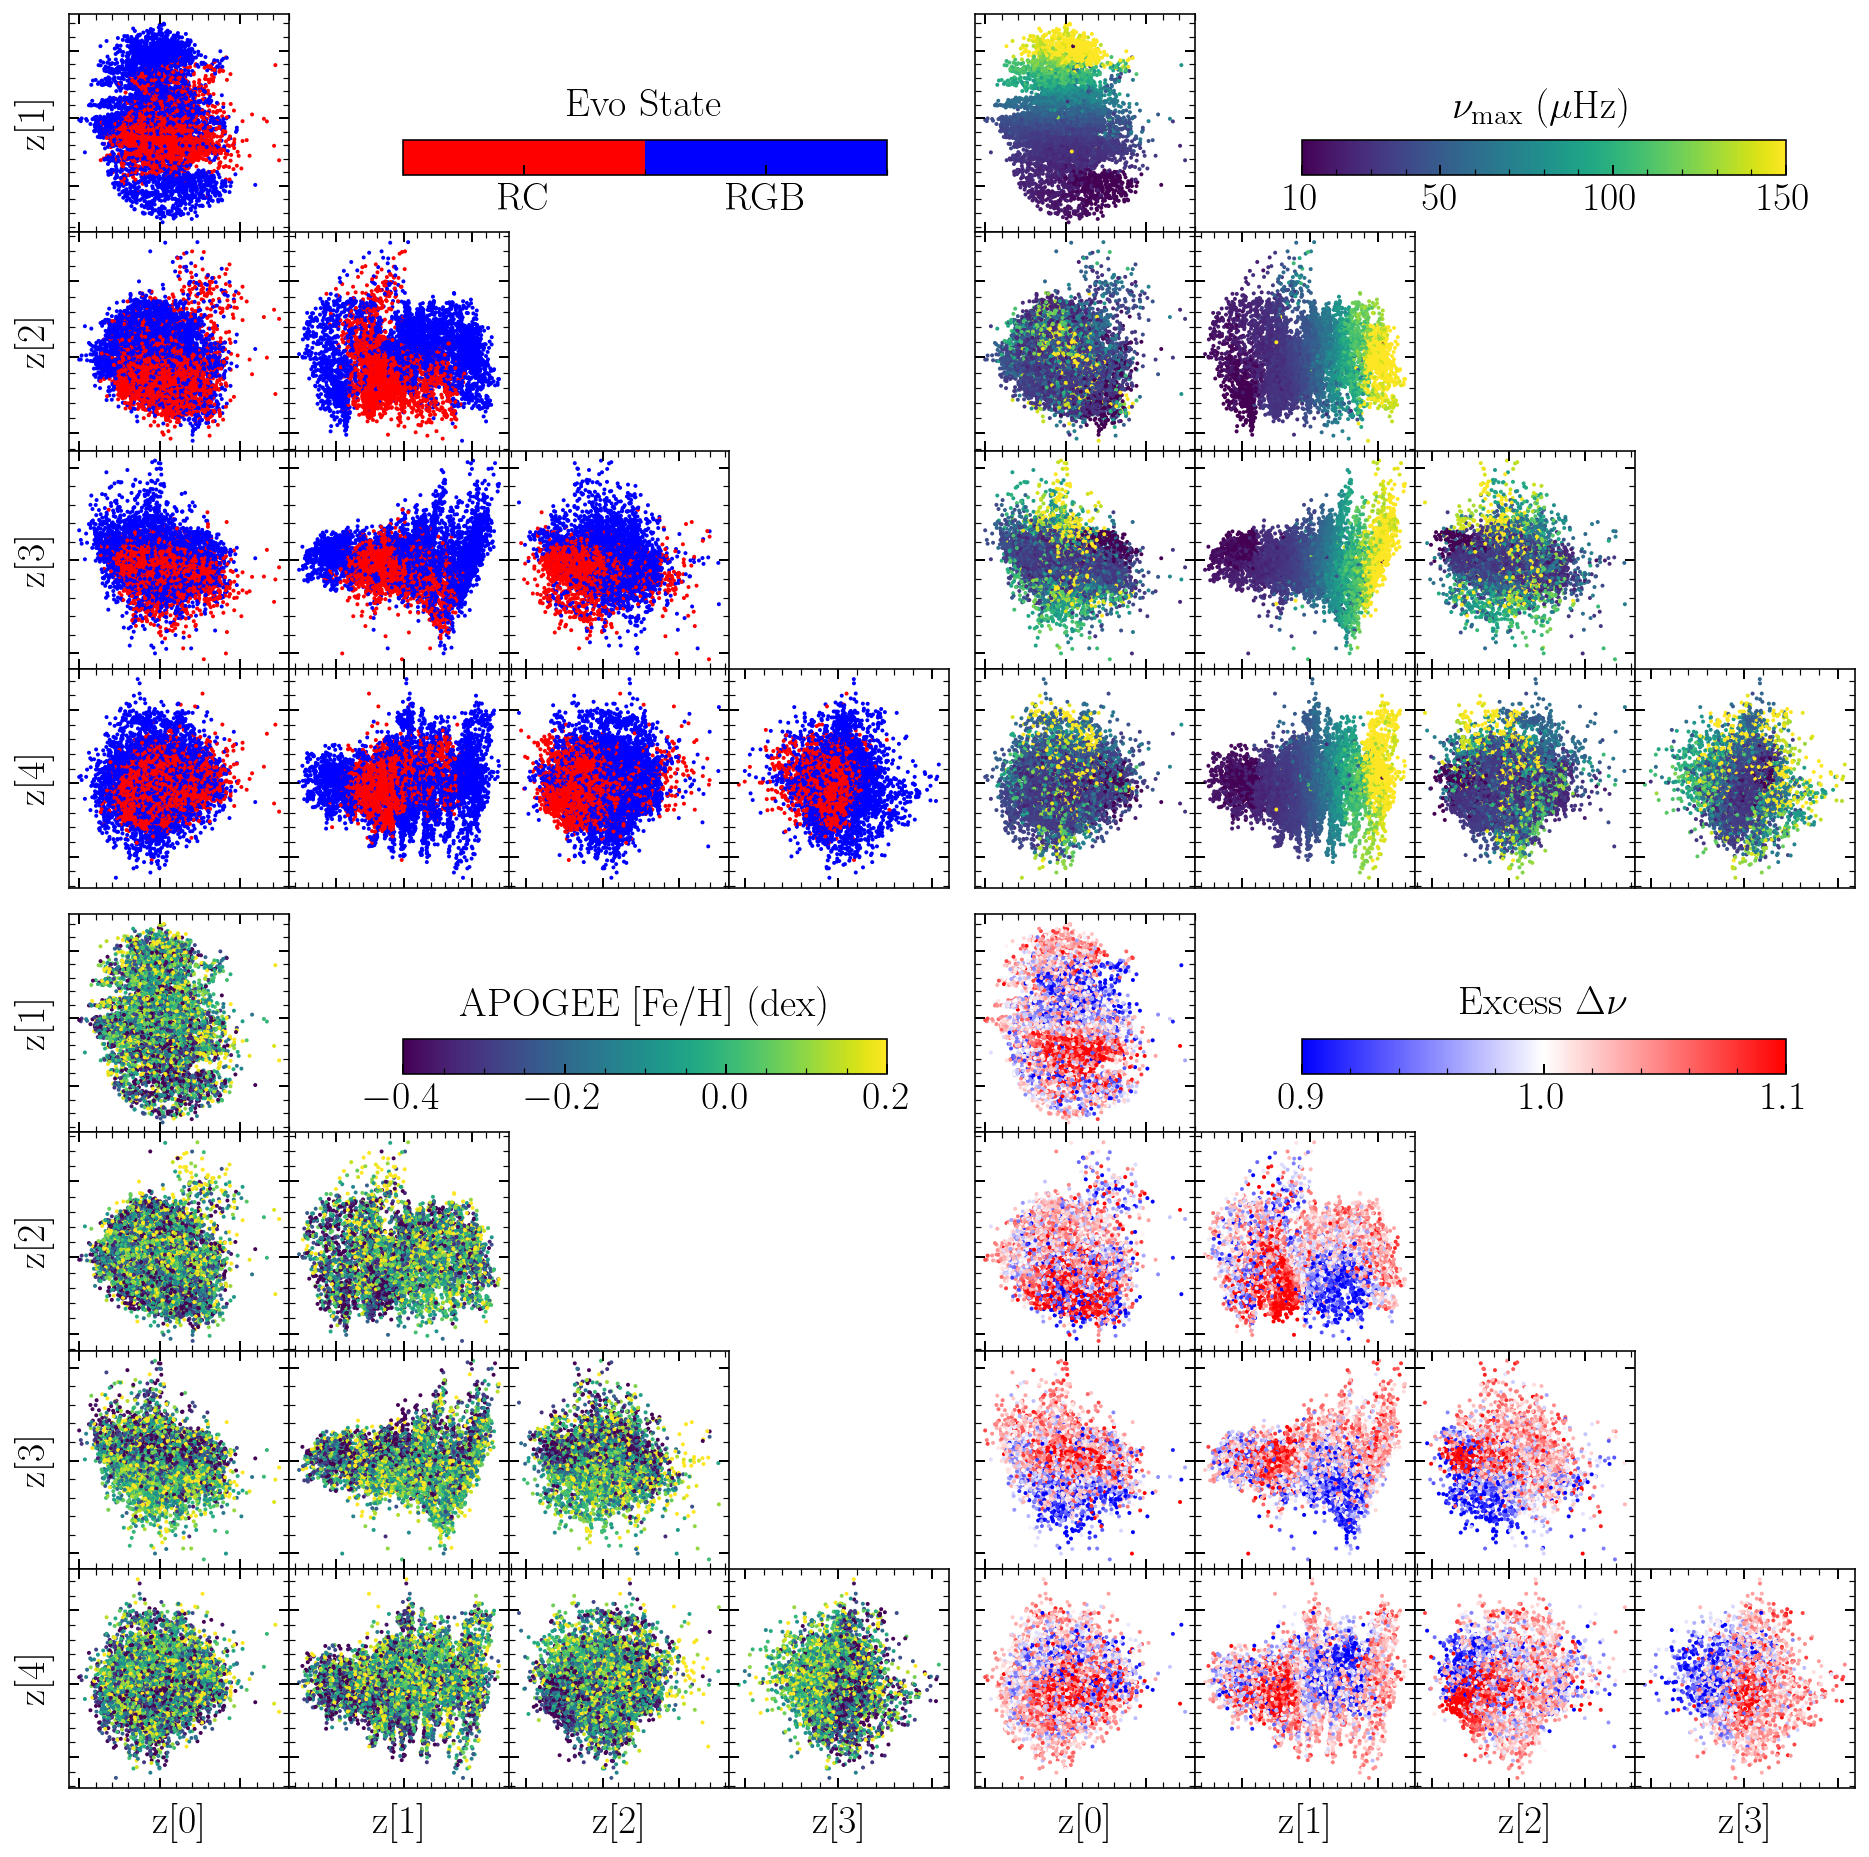

In [27]:
def corner(grids, z, label, vmin=None, vmax=None, cmap=None, rasterized=True, xtick=True, ytick=True):
    # , wspace=0, hspace=0
    axes = grids.subplots()
    if vmin is None:
        vmin = np.nanpercentile(label, 10)
    if vmax is None:
        vmax = np.nanpercentile(label, 90)

    for i in range(fig_dims):
        for j in range(fig_dims):
            if j > i:
                axes[i, j].set_visible(False)

            axes[i, j].axes.xaxis.set_ticklabels([])
            axes[i, j].axes.yaxis.set_ticklabels([])

            mappable = axes[i, j].scatter(
                z[:, j],
                z[:, i + 1],
                s=1,
                c=label,
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
                rasterized=rasterized,
            )

            if i == fig_dims - 1 and xtick:
                axes[i, j].set_xlabel(f"z[{j}]")
            if j == 0 and ytick:
                axes[i, j].set_ylabel(f"z[{i+1}]")
    return axes


fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(2, 2, wspace=0.03, hspace=0.03)
fig_dims = z.shape[1] - 1

for i in range(4):
    inner_grid = gs[i].subgridspec(fig_dims, fig_dims, wspace=0, hspace=0)
    if i == 0:
        axes = corner(
            inner_grid,
            z_mean[apokasc_f.dataset["Evostate"] > 0.0],
            apokasc_f.dataset["Evostate"][
                apokasc_f.dataset["Evostate"] > 0.0
            ],
            cmap="bwr",
            xtick=False,
        )
        cmap = mpl.colors.ListedColormap(["red", "blue"])
        norm = mpl.colors.BoundaryNorm([-1, 0, 1], 2, clip=True)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar_ax = fig.add_axes([0.27, 0.81, 0.21, 0.015])
        cbar = plt.colorbar(
            sm, orientation="horizontal", cax=cbar_ax, ticks=[-0.5, 0.5]
        )
        cbar.ax.set_xticklabels(["RC", "RGB"])
        cbar.set_label("Evo State", labelpad=-65, fontsize=20)
    if i == 1:
        axes = corner(
            inner_grid,
            z_mean,
            apokasc_f.dataset["Numax"],
            vmin=10,
            vmax=150,
            xtick=False,
            ytick=False,
        )

        cmap = mpl.cm.viridis
        norm = mpl.colors.Normalize(vmin=10, vmax=150)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar_ax = fig.add_axes([0.66, 0.81, 0.21, 0.015])
        cbar = plt.colorbar(
            sm, orientation="horizontal", cax=cbar_ax, ticks=[10, 50, 100, 150]
        )
        cbar.set_label(
            "$\\nu_{\mathrm{max}}$ ($\mu$Hz)", labelpad=-65, fontsize=20
        )
    if i == 2:
        axes = corner(
            inner_grid,
            z_mean,
            apokasc_f.allstar["FE_H"].filled(-9999.0),
            vmin=-0.4,
            vmax=0.2,
        )
        cmap = mpl.cm.viridis
        norm = mpl.colors.Normalize(vmin=-0.4, vmax=0.2)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar_ax = fig.add_axes([0.27, 0.42, 0.21, 0.015])
        cbar = plt.colorbar(sm, orientation="horizontal", cax=cbar_ax)
        cbar.set_label("APOGEE [Fe/H] (dex)", labelpad=-65, fontsize=20)
    if i == 3:
        axes = corner(
            inner_grid,
            z_mean,
            apokasc_f.dataset["EXCESS_DELTANU"],
            vmin=0.9,
            vmax=1.1,
            cmap="bwr",
            ytick=False
        )
        cmap = mpl.cm.bwr
        norm = mpl.colors.Normalize(vmin=0.9, vmax=1.1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar_ax = fig.add_axes([0.66, 0.42, 0.21, 0.015])
        cbar = plt.colorbar(sm, orientation="horizontal", cax=cbar_ax)
        cbar.set_label("Excess $\Delta\\nu$", labelpad=-65, fontsize=20)

# fig.tight_layout()
fig.savefig("./figs/latent_space_colored.pdf",bbox_inches="tight", dpi=120)

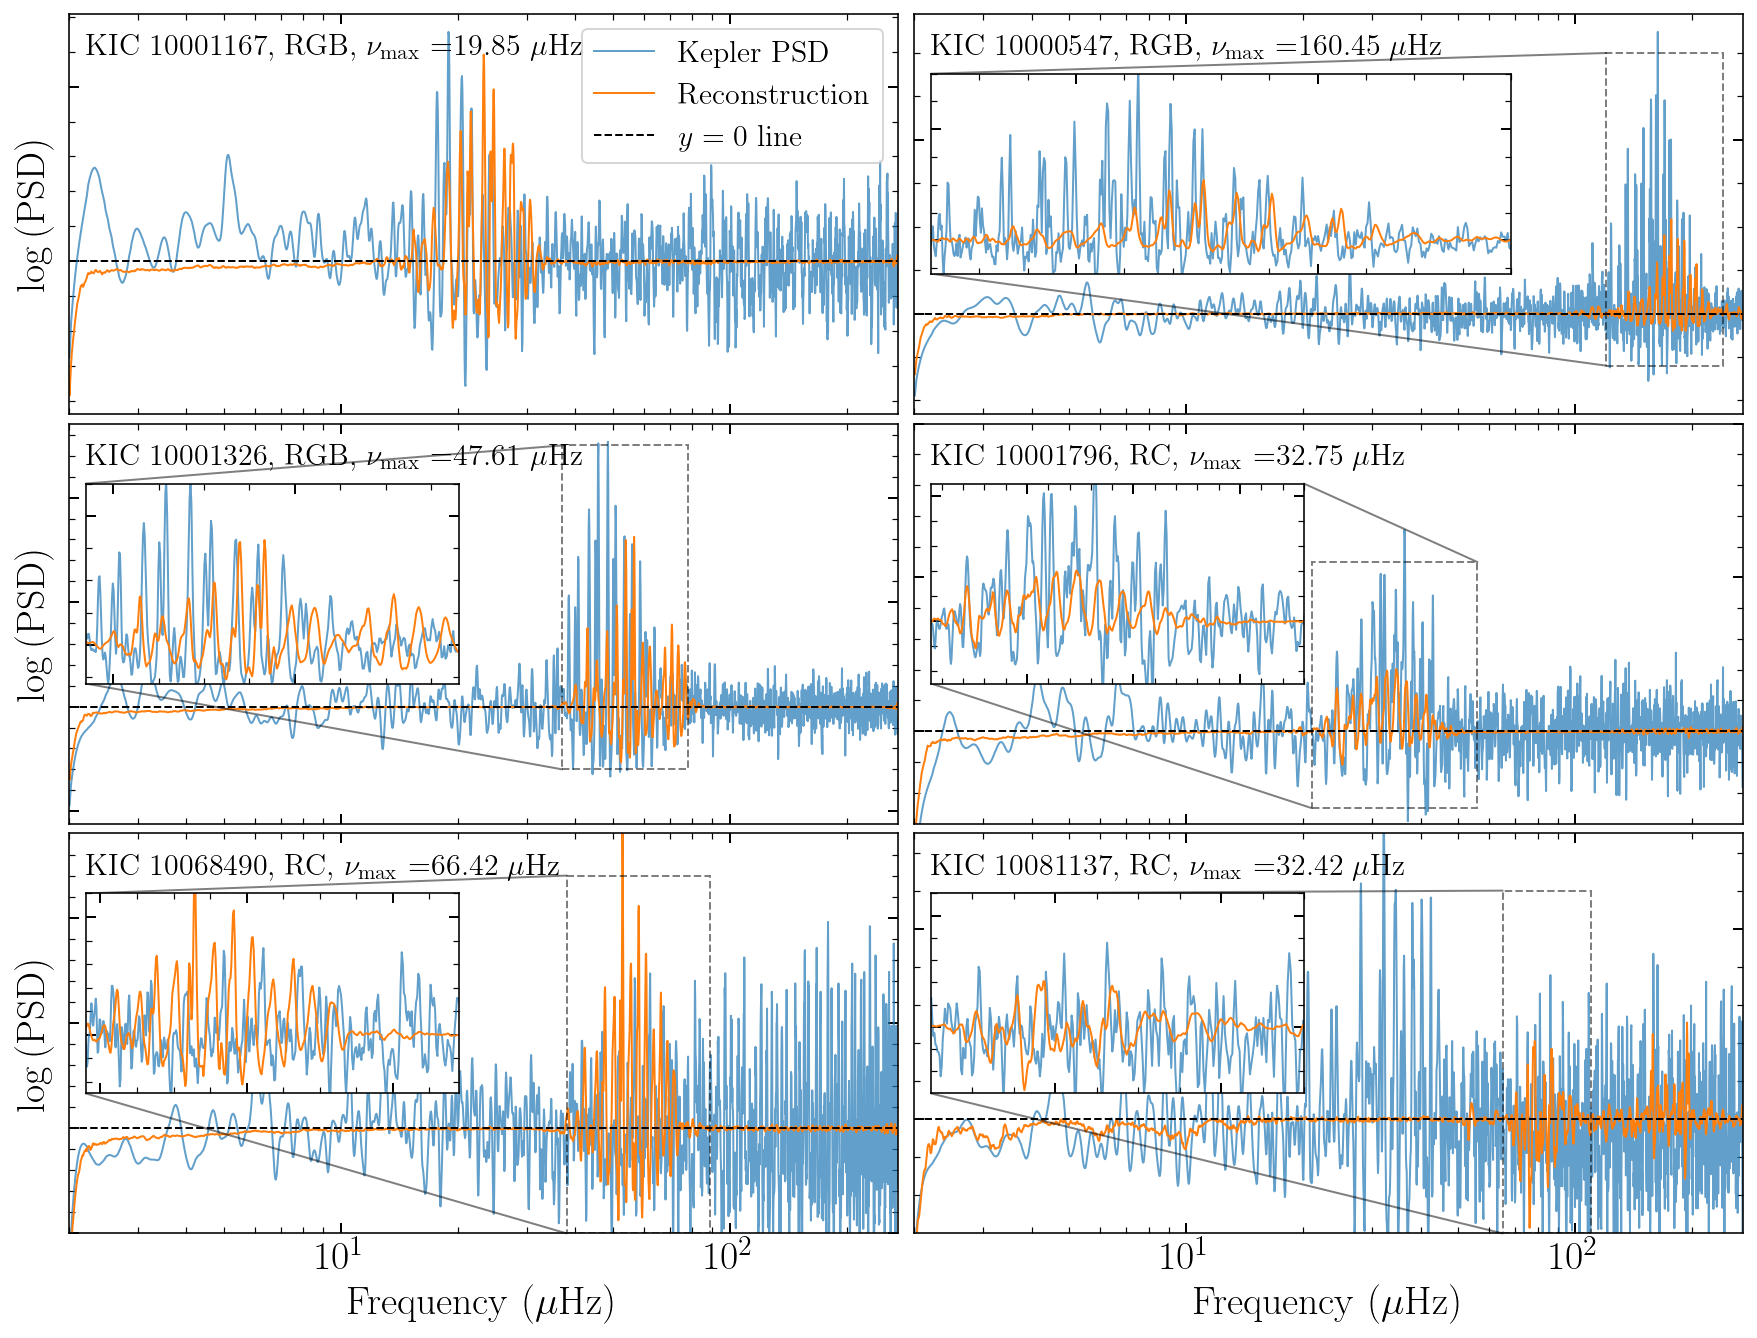

In [5]:
def plot_ax_recon(ax, apokasc_f, freq_range, y_true, y_pred, fmin=2, fmax=270, legend=False, legend_loc="lower left"):
    """
    plot comparison to reconstruction
    """
    ax.plot(freq_range, y_true, label="Kepler PSD", alpha=0.7, rasterized=True)
    ax.plot(freq_range, y_pred, label="Reconstruction", rasterized=True)
    ax.text(
        0.02,
        0.95,
        f"KIC {apokasc_f['KIC']}, {ES_num_to_word(apokasc_f['Evostate'])}, $\\nu_{{\mathrm{{max}}}}$ ={apokasc_f['Numax']:.2f} $\\mu$Hz",
        ha="left",
        va="top",
        fontsize=15,
        transform=ax.transAxes,
    )
    ax.axhline(0., ls="--", c="k", label="$y=0$ line")
    # ax.axvline(apokasc_f['Numax'], c="r", ls="--", label="$\\nu_{{\mathrm{{max}}}}$")
    ax.set_xlim(fmin, fmax)
    ax.set_xscale("log")
    
    if legend:
        ax.legend(loc=legend_loc)


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 11), gridspec_kw={"wspace": 0.02, "hspace": 0.025})

idx = np.where(apokasc_f.dataset["KIC"]==10001167)[0][0]
plot_ax_recon(ax1, apokasc_f.dataset[idx], freq_range, psd_training[idx], recont[idx], legend=True, legend_loc="upper right")
ax1.get_xaxis().set_ticklabels([])
ax1.get_yaxis().set_ticklabels([])
ax1.set_ylabel("$\log{(\mathrm{PSD})}$")
# axins = ax1.inset_axes([0.55, 0.35, 0.4, 0.5])
# axins.plot(freq_range, recont[4])
# axins.plot(freq_range, psd_training[4])
# axins.xaxis.set_ticklabels([])
# axins.yaxis.set_ticklabels([])
# axins.set_xlim(13, 35)
# axins.set_ylim(-0.6, 1.2)
# ax1.indicate_inset_zoom(axins, edgecolor="black", linestyle="--")

idx = np.where(apokasc_f.dataset["KIC"]==10000547)[0][0]
plot_ax_recon(ax2, apokasc_f.dataset[idx], freq_range, psd_training[idx], recont[idx])
ax2.get_xaxis().set_ticklabels([])
ax2.get_yaxis().set_ticklabels([])
axins = ax2.inset_axes([0.02, 0.35, 0.7, 0.5])
axins.plot(freq_range, psd_training[idx], alpha=0.7, rasterized=True)
axins.plot(freq_range, recont[idx], rasterized=True)
axins.xaxis.set_ticklabels([])
axins.yaxis.set_ticklabels([])
axins.set_xlim(120, 240)
axins.set_ylim(-0.6, 3.)
ax2.indicate_inset_zoom(axins, edgecolor="black", linestyle="--")

idx = np.where(apokasc_f.dataset["KIC"]==10001326)[0][0]
plot_ax_recon(ax3, apokasc_f.dataset[idx], freq_range, psd_training[idx], recont[idx])
ax3.get_xaxis().set_ticklabels([])
ax3.get_yaxis().set_ticklabels([])
ax3.set_ylabel("$\log{(\mathrm{PSD})}$")
axins = ax3.inset_axes([0.02, 0.35, 0.45, 0.5])
axins.plot(freq_range, psd_training[idx], alpha=0.7, rasterized=True)
axins.plot(freq_range, recont[idx], rasterized=True)
axins.xaxis.set_ticklabels([])
axins.yaxis.set_ticklabels([])
axins.set_xlim(37, 78)
axins.set_ylim(-0.6, 2.5)
ax3.indicate_inset_zoom(axins, edgecolor="black", linestyle="--")

idx = np.where(apokasc_f.dataset["KIC"]==10001796)[0][0]
plot_ax_recon(ax4, apokasc_f.dataset[idx], freq_range, psd_training[idx], recont[idx])
ax4.get_xaxis().set_ticklabels([])
ax4.get_yaxis().set_ticklabels([])
ax4.set_ylim(-0.6, 2.)
axins = ax4.inset_axes([0.02, 0.35, 0.45, 0.5])
axins.plot(freq_range, psd_training[idx], alpha=0.7, rasterized=True)
axins.plot(freq_range, recont[idx], rasterized=True)
axins.xaxis.set_ticklabels([])
axins.yaxis.set_ticklabels([])
axins.set_xlim(21, 56)
axins.set_ylim(-0.5, 1.1)
ax4.indicate_inset_zoom(axins, edgecolor="black", linestyle="--")

idx = np.where(apokasc_f.dataset["KIC"]==10068490)[0][0]
plot_ax_recon(ax5, apokasc_f.dataset[idx], freq_range, psd_training[idx], recont[idx])
ax5.get_yaxis().set_ticklabels([])
ax5.set_xlabel("Frequency ($\mu \mathrm{Hz}$)")
ax5.set_ylabel("$\log{(\mathrm{PSD})}$")
ax5.set_ylim(-0.5, 1.4)
axins = ax5.inset_axes([0.02, 0.35, 0.45, 0.5])
axins.plot(freq_range, psd_training[idx], alpha=0.7, rasterized=True)
axins.plot(freq_range, recont[idx], rasterized=True)
axins.xaxis.set_ticklabels([])
axins.yaxis.set_ticklabels([])
axins.set_xlim(38, 89)
axins.set_ylim(-0.5, 1.2)
ax5.indicate_inset_zoom(axins, edgecolor="black", linestyle="--")

idx = np.where(apokasc_f.dataset["KIC"]==10081137)[0][0]
plot_ax_recon(ax6, apokasc_f.dataset[idx], freq_range, psd_training[idx], recont[idx])
ax6.get_yaxis().set_ticklabels([])
ax6.set_xlabel("Frequency ($\mu \mathrm{Hz}$)")
ax6.set_ylim(-0.6, 1.5)
axins = ax6.inset_axes([0.02, 0.35, 0.45, 0.5])
axins.plot(freq_range, psd_training[idx], alpha=0.7, rasterized=True)
axins.plot(freq_range, recont[idx], rasterized=True)
axins.xaxis.set_ticklabels([])
axins.yaxis.set_ticklabels([])
axins.set_xlim(65, 110)
axins.set_ylim(-0.6, 1.2)
ax6.indicate_inset_zoom(axins, edgecolor="black", linestyle="--")

# fig.tight_layout()
fig.savefig("./figs/psd_reconstruction.pdf", bbox_inches="tight")

In [2]:
z = np.array([[0.857,  2.426, -0.249,  0.572, -0.019],
              [-0.154,  1.681,  0.802 ,  1.049 , -1.026],
              [0.889, -1.453, -0.985, -0.814, -0.766],
              [0.622 , -0.437, -0.571, -0.007, -0.124],
              [0.780, -3.058, -0.540,  0.674, -0.426],
              ])
recon_z = np.exp(model.keras_decoder(z)[:, :, 0])

# "impossible" latent space location
z_impossible = np.array([[2.5,-2,2.5,-2,2]])
recon_impossible = np.exp(model.keras_decoder(z_impossible)[0, :, 0])

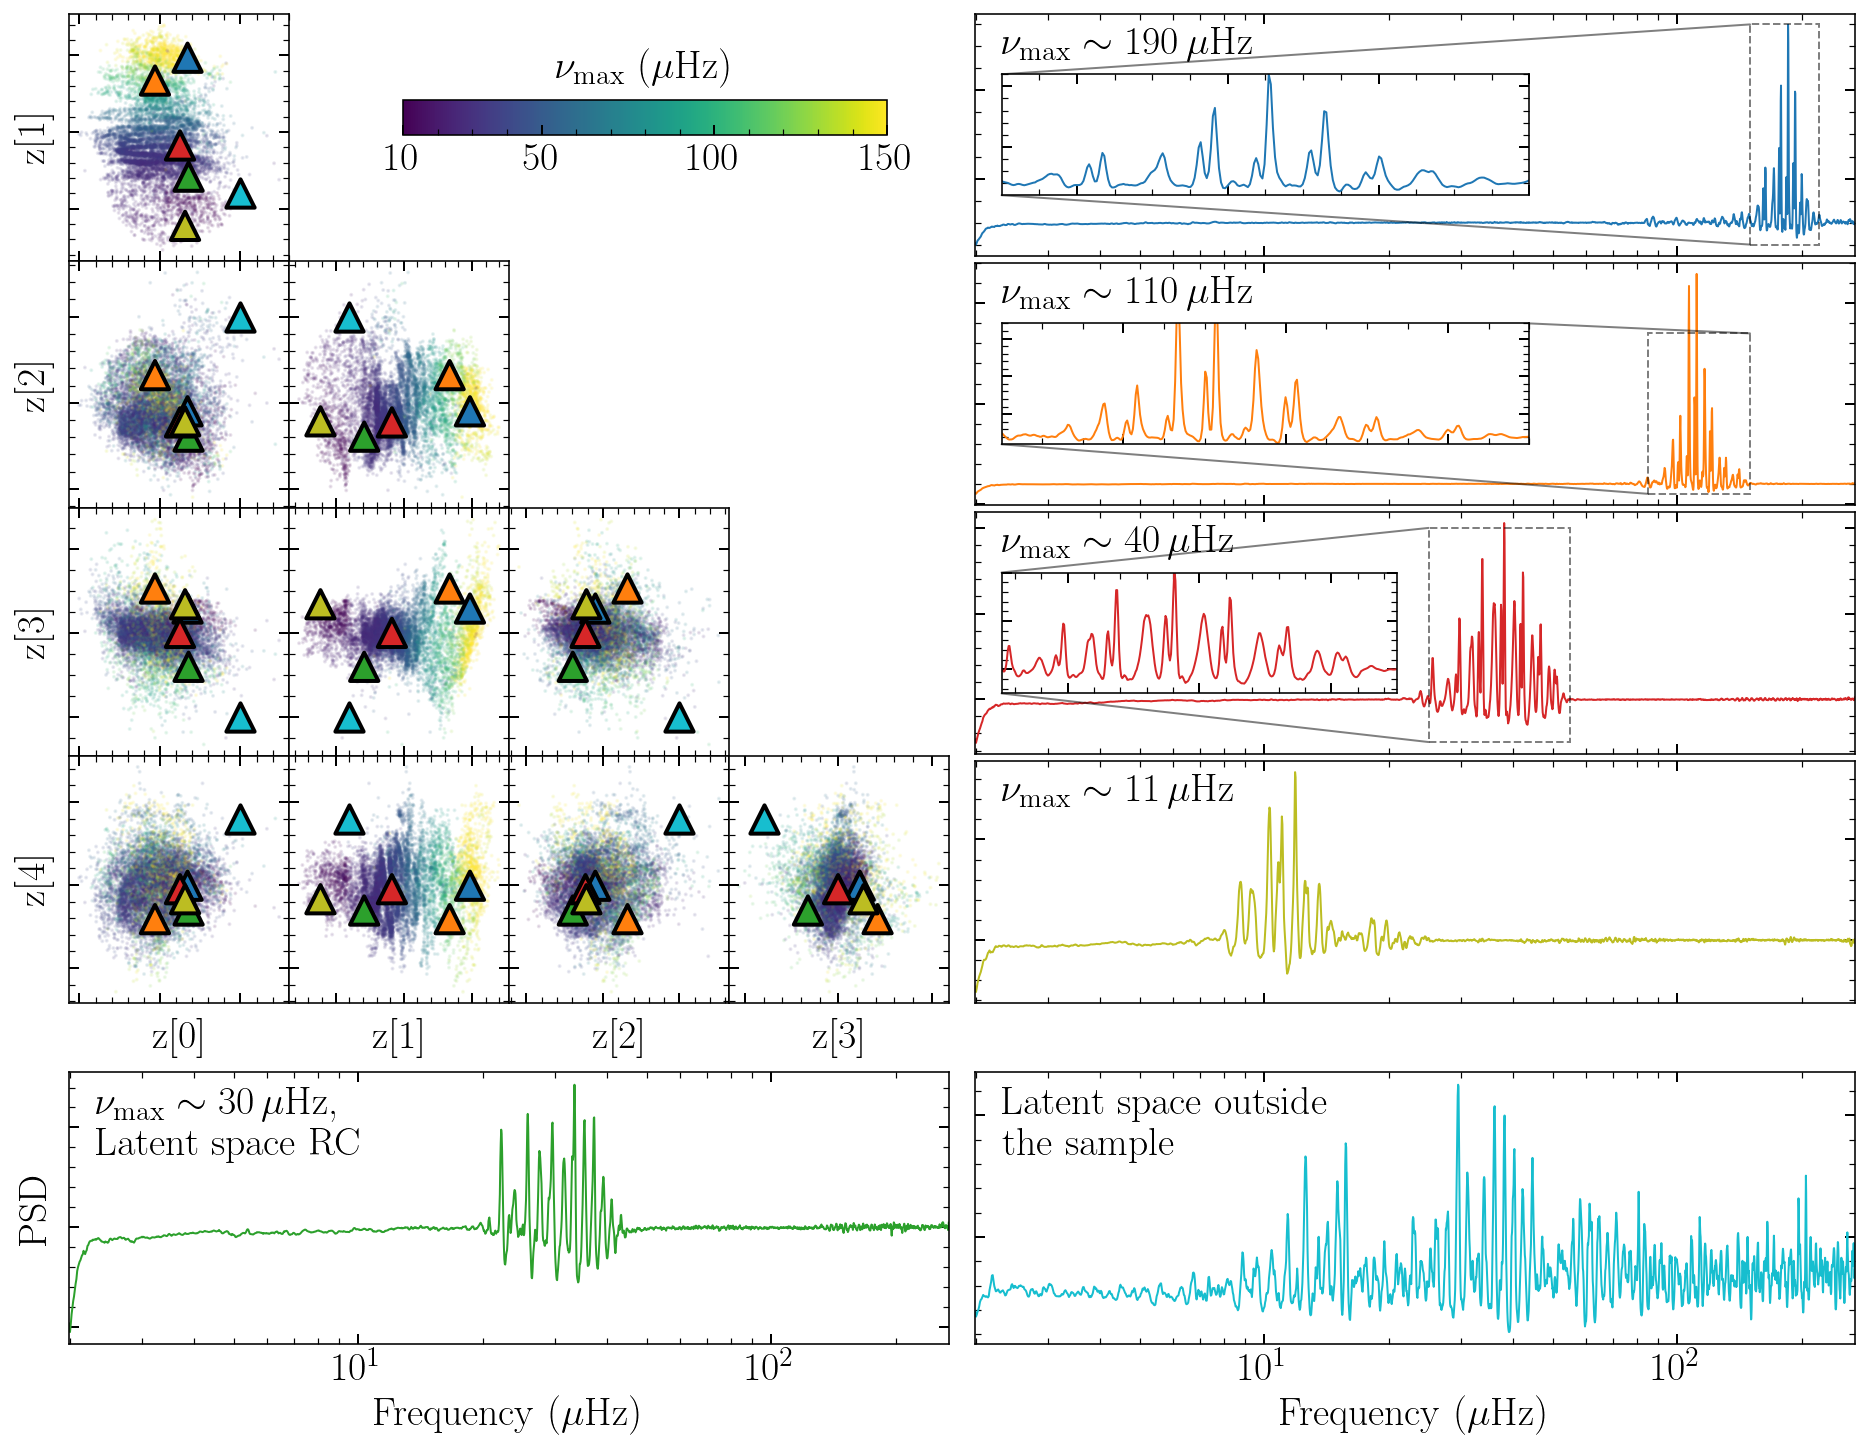

In [12]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[4, 1.1], hspace=0.11, wspace=0.03)
fig_dims = z.shape[1] - 1

inner_grid = gs[0].subgridspec(fig_dims, fig_dims, wspace=0, hspace=0)

def corner(grids, z, label, vmin=None, vmax=None, cmap=None, rasterized=True):
    # , wspace=0, hspace=0
    axes = grids.subplots()
    if vmin is None:
        vmin = np.nanpercentile(label, 10)
    if vmax is None:
        vmax = np.nanpercentile(label, 90)

    for i in range(fig_dims):
        for j in range(fig_dims):
            if j > i:
                axes[i, j].set_visible(False)

            axes[i, j].axes.xaxis.set_ticklabels([])
            axes[i, j].axes.yaxis.set_ticklabels([])

            mappable = axes[i, j].scatter(
                z[:, j],
                z[:, i + 1],
                s=1,
                c=label,
                alpha=0.1,
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
                rasterized=rasterized,
            )

            if i == fig_dims - 1:
                axes[i, j].set_xlabel(f"z[{j}]")
            if j == 0:
                axes[i, j].set_ylabel(f"z[{i+1}]")
    return axes

axes = corner(
    inner_grid,
    z_mean,
    apokasc_f.dataset["Numax"],
    vmin=10,
    vmax=150,
)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=10, vmax=150)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.27, 0.81, 0.21, 0.02])
cbar = plt.colorbar(
    sm, orientation="horizontal", cax=cbar_ax, ticks=[10, 50, 100, 150]
)
cbar.set_label(
    "$\\nu_{\mathrm{max}}$ ($\mu$Hz)", labelpad=-65, fontsize=20
)

# ====================== add z ========================
for i in range(fig_dims):
    for j in range(fig_dims):
        if j > i:
            axes[i, j].set_visible(False)

        axes[i, j].axes.xaxis.set_ticklabels([])
        axes[i, j].axes.yaxis.set_ticklabels([])

        mappable = axes[i, j].scatter(
            z[:, j],
            z[:, i + 1],
            s=200,
            c=["C0", "C1", "C2", "C3", "C8"],
            edgecolor=["k", "k", "k", "k", "k"],
            marker="^",
            linewidths=2,
        )
        mappable = axes[i, j].scatter(
            z_impossible[:, j],
            z_impossible[:, i + 1],
            s=200,
            edgecolor=["k"],
            c=["C9"],
            marker="^",
            linewidths=2,
        )
# ====================== add z ========================
      

inner_grid = gs[1].subgridspec(4, 1, hspace=0.03)
axes = inner_grid.subplots()

axes[0].plot(freq_range, recon_z[0], c="C0")
axes[0].set_xlim(freq_range[0], freq_range[-1])
axes[0].set_xscale("log")
axes[0].axes.xaxis.set_ticklabels([])
axes[0].axes.yaxis.set_ticklabels([])
axes[0].text(
    0.03,
    0.95,
    "$\\nu_{\mathrm{max}}\sim 190\,\mu$Hz",
    ha="left",
    va="top",
    fontsize=20,
    transform=axes[0].transAxes,
)
axins = axes[0].inset_axes([0.03, 0.25, 0.6, 0.5])
axins.plot(freq_range, recon_z[0])
axins.xaxis.set_ticklabels([])
axins.yaxis.set_ticklabels([])
axins.set_xlim(150, 220)
axins.set_ylim(0.5, 5.5)
axes[0].indicate_inset_zoom(axins, edgecolor="black", linestyle="--")

axes[1].plot(freq_range, recon_z[1], c="C1")
axes[1].set_xlim(freq_range[0], freq_range[-1])
axes[1].set_xscale("log")
axes[1].axes.xaxis.set_ticklabels([])
axes[1].axes.yaxis.set_ticklabels([])
axes[1].text(
    0.03,
    0.95,
    "$\\nu_{\mathrm{max}}\sim 110\,\mu$Hz",
    ha="left",
    va="top",
    fontsize=20,
    transform=axes[1].transAxes,
)
axins = axes[1].inset_axes([0.03, 0.25, 0.6, 0.5])
axins.plot(freq_range, recon_z[1], c="C1")
axins.xaxis.set_ticklabels([])
axins.yaxis.set_ticklabels([])
axins.set_xlim(85, 150)
axins.set_ylim(0.5, 8.5)
axes[1].indicate_inset_zoom(axins, edgecolor="black", linestyle="--")

axes[2].plot(freq_range, recon_z[3], c="C3")
axes[2].set_xlim(freq_range[0], freq_range[-1])
axes[2].set_xscale("log")
axes[2].axes.xaxis.set_ticklabels([])
axes[2].axes.yaxis.set_ticklabels([])
axes[2].text(
    0.03,
    0.95,
    "$\\nu_{\mathrm{max}}\sim 40\,\mu$Hz",
    ha="left",
    va="top",
    fontsize=20,
    transform=axes[2].transAxes,
)
axins = axes[2].inset_axes([0.03, 0.25, 0.45, 0.5])
axins.plot(freq_range, recon_z[3], c="C3")
axins.xaxis.set_ticklabels([])
axins.yaxis.set_ticklabels([])
axins.set_xlim(25, 55)
axins.set_ylim(0.5, 3.0)
axes[2].indicate_inset_zoom(axins, edgecolor="black", linestyle="--")

axes[3].plot(freq_range, recon_z[4], c="C8")
axes[3].set_xlim(freq_range[0], freq_range[-1])
axes[3].set_xscale("log")
axes[3].axes.xaxis.set_ticklabels([])
axes[3].axes.yaxis.set_ticklabels([])
axes[3].text(
    0.03,
    0.95,
    "$\\nu_{\mathrm{max}}\sim 11\,\mu$Hz",
    ha="left",
    va="top",
    fontsize=20,
    transform=axes[3].transAxes,
)

inner_grid = gs[2].subgridspec(1, 1)
ax = inner_grid.subplots()
ax.plot(freq_range, recon_z[2], c="C2")
ax.set_xlim(freq_range[0], freq_range[-1])
ax.axes.yaxis.set_ticklabels([])
ax.set_xscale("log")
ax.set_xlabel("Frequency ($\mu \mathrm{Hz}$)")
ax.set_ylabel("PSD")
ax.text(
    0.03,
    0.95,
    "$\\nu_{\mathrm{max}}\sim 30\,\mu$Hz, \nLatent space RC",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax.transAxes,
)

inner_grid = gs[3].subgridspec(1, 1)
ax = inner_grid.subplots()
ax.plot(freq_range, recon_impossible, c="C9")
ax.set_xlim(freq_range[0], freq_range[-1])
ax.axes.yaxis.set_ticklabels([])
ax.set_xscale("log")
ax.set_xlabel("Frequency ($\mu \mathrm{Hz}$)")
ax.text(
    0.03,
    0.95,
    "Latent space outside \nthe sample",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax.transAxes,
)

# fig.tight_layout()
fig.savefig("./figs/latent_space_recon.pdf", bbox_inches="tight", dpi=144)